In [ ]:
# 04_latent_dynamics_training.ipynb
# =============================================
# Action-Conditioned Latent Dynamics Training
# Predicts next latent state z_{t+1} from z_t + action_t
# Uses pretrained VAE for encoding/decoding

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
from io import BytesIO
import h5py

# Import your dataset class
from models.data_loader import RoboNetDataset

# ────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────

PROJECT_ROOT = r"E:\NVIDIA_PROJECTS\Neural-World-Model-for-Embodied-AI-Robotics\neural-world-model-robotics"
DATA_ROOT    = os.path.join(PROJECT_ROOT, "data", "raw", "robonet", "hdf5")
SPLITS_PATH  = os.path.join(PROJECT_ROOT, "data", "splits.json")
VAE_CHECKPOINT = os.path.join(PROJECT_ROOT, "checkpoints", "vae_pretrained.pth")
SAVE_DIR     = os.path.join(PROJECT_ROOT, "checkpoints")
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE    = 4
NUM_WORKERS   = 0
EPOCHS        = 50
LR            = 3e-4
LATENT_DIM    = 128
HIDDEN_DIM    = 256
SEQ_LEN       = 31          # full sequence length from your data

# ────────────────────────────────────────────────
# 1. Load train/val splits
# ────────────────────────────────────────────────

print("Loading splits...")
with open(SPLITS_PATH, "r") as f:
    splits = json.load(f)

train_files = splits["train"]
val_files   = splits["val"]

print(f"Train: {len(train_files)} | Val: {len(val_files)}")

# ────────────────────────────────────────────────
# 2. Datasets & Loaders
# ────────────────────────────────────────────────

train_dataset = RoboNetDataset(train_files, DATA_ROOT, resize_to=(128, 128))
val_dataset   = RoboNetDataset(val_files,   DATA_ROOT, resize_to=(128, 128))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# ────────────────────────────────────────────────
# 3. Pretrained VAE (copy your exact class from pretraining notebook)
# ────────────────────────────────────────────────

class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder (MUST match your pretrained model exactly)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512), nn.ReLU()
        )
        self.fc_mu     = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder (MUST match exactly)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512), nn.ReLU(),
            nn.Linear(512, 256 * 8 * 8), nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# Load and freeze VAE
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
vae.load_state_dict(torch.load(VAE_CHECKPOINT))
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

print("Pretrained VAE loaded and frozen")

# ────────────────────────────────────────────────
# 4. Latent Dynamics Model
# ────────────────────────────────────────────────

class LatentDynamics(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.gru = nn.GRUCell(latent_dim + 4, hidden_dim)
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_prev, action, h_prev=None):
        if h_prev is None:
            h_prev = torch.zeros(z_prev.size(0), self.gru.hidden_size, device=z_prev.device)

        inp = torch.cat([z_prev, action], dim=-1)
        h = self.gru(inp, h_prev)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z_next = self.reparameterize(mu, logvar)
        return z_next, mu, logvar, h

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


dynamics = LatentDynamics().to(DEVICE)
optimizer = optim.Adam(dynamics.parameters(), lr=LR)

def dynamics_loss(z_pred, z_true, mu, logvar):
    recon_loss = nn.functional.mse_loss(z_pred, z_true, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.1 * kl_loss  # KL weight = 0.1


print("Dynamics model created. Parameters:", sum(p.numel() for p in dynamics.parameters()))

# ────────────────────────────────────────────────
# 5. Training Loop
# ────────────────────────────────────────────────

best_val_loss = float('inf')
checkpoint_path = os.path.join(SAVE_DIR, "latent_dynamics_best.pth")

for epoch in range(EPOCHS):
    dynamics.train()
    train_loss = 0.0
    num_batches = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        frames = batch['frames'].to(DEVICE)
        actions = batch['actions'].to(DEVICE)

        B, T = frames.shape[0], frames.shape[1]

        # Encode all frames to latents (frozen VAE)
        with torch.no_grad():
            x_flat = frames.view(-1, 3, 128, 128)
            mu_all, logvar_all = vae.encode(x_flat)
            z_all = vae.reparameterize(mu_all, logvar_all).view(B, T, LATENT_DIM)

        loss = 0.0
        h = None
        for t in range(T-1):
            z_curr = z_all[:, t]
            a_t = actions[:, t]
            z_next_pred, mu, logvar, h = dynamics(z_curr, a_t, h)
            z_next_true = z_all[:, t+1]
            loss += dynamics_loss(z_next_pred, z_next_true, mu, logvar)

        loss = loss / (T-1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    avg_train_loss = train_loss / num_batches

    # Validation
    dynamics.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            frames = batch['frames'].to(DEVICE)
            actions = batch['actions'].to(DEVICE)
            B, T = frames.shape[0], frames.shape[1]

            x_flat = frames.view(-1, 3, 128, 128)
            mu_all, logvar_all = vae.encode(x_flat)
            z_all = vae.reparameterize(mu_all, logvar_all).view(B, T, LATENT_DIM)

            h = None
            batch_loss = 0.0
            for t in range(T-1):
                z_curr = z_all[:, t]
                a_t = actions[:, t]
                z_next_pred, mu, logvar, h = dynamics(z_curr, a_t, h)
                z_next_true = z_all[:, t+1]
                batch_loss += dynamics_loss(z_next_pred, z_next_true, mu, logvar).item()

            val_loss += batch_loss / (T-1)

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(dynamics.state_dict(), checkpoint_path)
        print(f"Best dynamics saved (val loss: {best_val_loss:.4f})")

print("Training finished!")
print(f"Best checkpoint: {checkpoint_path}")

# ────────────────────────────────────────────────
# 6. 10-Step Open-Loop Rollout Visualization
# ────────────────────────────────────────────────

dynamics.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    frames = batch['frames'].to(DEVICE)
    actions = batch['actions'].to(DEVICE)

    B, T = frames.shape[0], frames.shape[1]

    x_flat = frames.view(-1, 3, 128, 128)
    mu_all, logvar_all = vae.encode(x_flat)
    z_gt = vae.reparameterize(mu_all, logvar_all).view(B, T, LATENT_DIM)

    start_t = T // 2
    z_current = z_gt[:, start_t:start_t+1]
    h = None

    num_steps = 10
    pred_frames = []
    for step in range(num_steps):
        a_t = actions[:, min(start_t + step, actions.shape[1]-1)]
        z_next, _, _, h = dynamics(z_current.squeeze(1), a_t, h)
        recon = vae.decode(z_next)
        pred_frames.append(recon[0].cpu().permute(1, 2, 0).numpy())
        z_current = z_next.unsqueeze(1)

    gt_next = [frames[0, min(start_t + i + 1, T-1)].cpu().permute(1, 2, 0).numpy() for i in range(num_steps)]

    fig, axes = plt.subplots(2, num_steps + 1, figsize=(20, 6))
    axes[0, 0].imshow(frames[0, start_t].cpu().permute(1, 2, 0).numpy())
    axes[0, 0].set_title("Current (t)")
    axes[1, 0].axis('off')

    for i in range(num_steps):
        axes[0, i+1].imshow(pred_frames[i])
        axes[0, i+1].set_title(f"Pred t+{i+1}")
        axes[1, i+1].imshow(gt_next[i])
        axes[1, i+1].set_title(f"GT t+{i+1}")
        for ax in [axes[0, i+1], axes[1, i+1]]:
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle("10-Step Open-Loop Rollout", y=1.02)
    plt.show()

✓ Pretrained VAE loaded successfully.
VAE Output Variance: 0.010509


Epoch 1/100: 100%|██████████| 140/140 [00:21<00:00,  6.39it/s]


Epoch 1 Loss: 786.4105


Epoch 2/100: 100%|██████████| 140/140 [00:42<00:00,  3.28it/s]


Epoch 2 Loss: 604.2494


Epoch 3/100: 100%|██████████| 140/140 [00:44<00:00,  3.14it/s]


Epoch 3 Loss: 576.6515


Epoch 4/100: 100%|██████████| 140/140 [00:46<00:00,  3.02it/s]


Epoch 4 Loss: 556.6739


Epoch 5/100: 100%|██████████| 140/140 [00:48<00:00,  2.89it/s]


Epoch 5 Loss: 542.9506


Epoch 6/100: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


Epoch 6 Loss: 533.0758


Epoch 7/100: 100%|██████████| 140/140 [00:39<00:00,  3.51it/s]


Epoch 7 Loss: 527.8344


Epoch 8/100: 100%|██████████| 140/140 [00:39<00:00,  3.58it/s]


Epoch 8 Loss: 523.6357


Epoch 9/100: 100%|██████████| 140/140 [00:43<00:00,  3.19it/s]


Epoch 9 Loss: 521.5324


Epoch 10/100: 100%|██████████| 140/140 [00:47<00:00,  2.92it/s]


Epoch 10 Loss: 519.6604


Epoch 11/100: 100%|██████████| 140/140 [00:47<00:00,  2.93it/s]


Epoch 11 Loss: 517.6920


Epoch 12/100: 100%|██████████| 140/140 [00:47<00:00,  2.96it/s]


Epoch 12 Loss: 516.1871


Epoch 13/100: 100%|██████████| 140/140 [00:48<00:00,  2.87it/s]


Epoch 13 Loss: 516.0665


Epoch 14/100: 100%|██████████| 140/140 [00:42<00:00,  3.33it/s]


Epoch 14 Loss: 513.5633


Epoch 15/100: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 15 Loss: 512.6799


Epoch 16/100: 100%|██████████| 140/140 [00:46<00:00,  2.98it/s]


Epoch 16 Loss: 513.4169


Epoch 17/100: 100%|██████████| 140/140 [00:47<00:00,  2.94it/s]


Epoch 17 Loss: 511.7103


Epoch 18/100: 100%|██████████| 140/140 [00:47<00:00,  2.92it/s]


Epoch 18 Loss: 511.0631


Epoch 19/100: 100%|██████████| 140/140 [00:47<00:00,  2.95it/s]


Epoch 19 Loss: 510.5271


Epoch 20/100: 100%|██████████| 140/140 [00:45<00:00,  3.06it/s]


Epoch 20 Loss: 511.2398


Epoch 21/100: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 21 Loss: 510.6152


Epoch 22/100: 100%|██████████| 140/140 [00:40<00:00,  3.48it/s]


Epoch 22 Loss: 510.8480


Epoch 23/100: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s]


Epoch 23 Loss: 509.4020


Epoch 24/100: 100%|██████████| 140/140 [00:46<00:00,  3.02it/s]


Epoch 24 Loss: 510.2664


Epoch 25/100: 100%|██████████| 140/140 [00:46<00:00,  3.00it/s]


Epoch 25 Loss: 509.0273


Epoch 26/100: 100%|██████████| 140/140 [00:49<00:00,  2.86it/s]


Epoch 26 Loss: 509.3521


Epoch 27/100: 100%|██████████| 140/140 [00:40<00:00,  3.46it/s]


Epoch 27 Loss: 509.2700


Epoch 28/100: 100%|██████████| 140/140 [00:48<00:00,  2.91it/s]


Epoch 28 Loss: 508.8939


Epoch 29/100: 100%|██████████| 140/140 [00:41<00:00,  3.40it/s]


Epoch 29 Loss: 509.9259


Epoch 30/100: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s]


Epoch 30 Loss: 509.9988


Epoch 31/100: 100%|██████████| 140/140 [00:42<00:00,  3.30it/s]


Epoch 31 Loss: 508.8767


Epoch 32/100: 100%|██████████| 140/140 [00:48<00:00,  2.87it/s]


Epoch 32 Loss: 508.4549


Epoch 33/100: 100%|██████████| 140/140 [00:45<00:00,  3.06it/s]


Epoch 33 Loss: 509.5509


Epoch 34/100: 100%|██████████| 140/140 [00:49<00:00,  2.82it/s]


Epoch 34 Loss: 508.2614


Epoch 35/100: 100%|██████████| 140/140 [00:44<00:00,  3.17it/s]


Epoch 35 Loss: 509.2496


Epoch 36/100: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


Epoch 36 Loss: 508.8203


Epoch 37/100: 100%|██████████| 140/140 [00:46<00:00,  2.98it/s]


Epoch 37 Loss: 509.1962


Epoch 38/100: 100%|██████████| 140/140 [00:47<00:00,  2.92it/s]


Epoch 38 Loss: 509.6365


Epoch 39/100: 100%|██████████| 140/140 [00:46<00:00,  2.99it/s]


Epoch 39 Loss: 509.0605


Epoch 40/100: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 40 Loss: 509.6101


Epoch 41/100: 100%|██████████| 140/140 [00:43<00:00,  3.20it/s]


Epoch 41 Loss: 508.1300


Epoch 42/100: 100%|██████████| 140/140 [00:47<00:00,  2.97it/s]


Epoch 42 Loss: 507.6028


Epoch 43/100: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 43 Loss: 506.8637


Epoch 44/100: 100%|██████████| 140/140 [00:45<00:00,  3.08it/s]


Epoch 44 Loss: 508.9284


Epoch 45/100: 100%|██████████| 140/140 [00:46<00:00,  3.04it/s]


Epoch 45 Loss: 507.2148


Epoch 46/100: 100%|██████████| 140/140 [00:42<00:00,  3.29it/s]


Epoch 46 Loss: 509.3218


Epoch 47/100: 100%|██████████| 140/140 [00:42<00:00,  3.33it/s]


Epoch 47 Loss: 508.7939


Epoch 48/100: 100%|██████████| 140/140 [00:40<00:00,  3.46it/s]


Epoch 48 Loss: 508.8460


Epoch 49/100: 100%|██████████| 140/140 [00:42<00:00,  3.33it/s]


Epoch 49 Loss: 509.6464


Epoch 50/100: 100%|██████████| 140/140 [00:43<00:00,  3.24it/s]


Epoch 50 Loss: 508.8513


Epoch 51/100: 100%|██████████| 140/140 [00:42<00:00,  3.28it/s]


Epoch 51 Loss: 508.1494


Epoch 52/100: 100%|██████████| 140/140 [00:42<00:00,  3.30it/s]


Epoch 52 Loss: 508.0002


Epoch 53/100: 100%|██████████| 140/140 [00:41<00:00,  3.40it/s]


Epoch 53 Loss: 508.6962


Epoch 54/100: 100%|██████████| 140/140 [00:40<00:00,  3.42it/s]


Epoch 54 Loss: 507.5611


Epoch 55/100: 100%|██████████| 140/140 [00:41<00:00,  3.40it/s]


Epoch 55 Loss: 508.7087


Epoch 56/100: 100%|██████████| 140/140 [00:41<00:00,  3.40it/s]


Epoch 56 Loss: 507.3765


Epoch 57/100: 100%|██████████| 140/140 [00:40<00:00,  3.44it/s]


Epoch 57 Loss: 508.3847


Epoch 58/100: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 58 Loss: 506.4736


Epoch 59/100: 100%|██████████| 140/140 [00:42<00:00,  3.30it/s]


Epoch 59 Loss: 509.0742


Epoch 60/100: 100%|██████████| 140/140 [00:41<00:00,  3.35it/s]


Epoch 60 Loss: 509.1512


Epoch 61/100: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 61 Loss: 508.1141


Epoch 62/100: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s]


Epoch 62 Loss: 508.8199


Epoch 63/100: 100%|██████████| 140/140 [00:51<00:00,  2.73it/s]


Epoch 63 Loss: 509.0889


Epoch 64/100: 100%|██████████| 140/140 [00:40<00:00,  3.43it/s]


Epoch 64 Loss: 507.4277


Epoch 65/100: 100%|██████████| 140/140 [00:42<00:00,  3.33it/s]


Epoch 65 Loss: 507.5973


Epoch 66/100: 100%|██████████| 140/140 [00:41<00:00,  3.35it/s]


Epoch 66 Loss: 507.7124


Epoch 67/100: 100%|██████████| 140/140 [00:41<00:00,  3.35it/s]


Epoch 67 Loss: 508.6648


Epoch 68/100: 100%|██████████| 140/140 [00:41<00:00,  3.35it/s]


Epoch 68 Loss: 507.1593


Epoch 69/100: 100%|██████████| 140/140 [00:39<00:00,  3.51it/s]


Epoch 69 Loss: 507.7558


Epoch 70/100: 100%|██████████| 140/140 [00:41<00:00,  3.34it/s]


Epoch 70 Loss: 508.2904


Epoch 71/100: 100%|██████████| 140/140 [00:41<00:00,  3.34it/s]


Epoch 71 Loss: 508.1871


Epoch 72/100: 100%|██████████| 140/140 [00:42<00:00,  3.30it/s]


Epoch 72 Loss: 508.0922


Epoch 73/100: 100%|██████████| 140/140 [00:43<00:00,  3.25it/s]


Epoch 73 Loss: 509.1875


Epoch 74/100: 100%|██████████| 140/140 [00:46<00:00,  3.02it/s]


Epoch 74 Loss: 508.6373


Epoch 75/100: 100%|██████████| 140/140 [00:43<00:00,  3.23it/s]


Epoch 75 Loss: 509.0797


Epoch 76/100: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 76 Loss: 508.4133


Epoch 77/100: 100%|██████████| 140/140 [00:42<00:00,  3.26it/s]


Epoch 77 Loss: 508.8683


Epoch 78/100: 100%|██████████| 140/140 [00:42<00:00,  3.27it/s]


Epoch 78 Loss: 507.8252


Epoch 79/100: 100%|██████████| 140/140 [13:10<00:00,  5.65s/it]  


Epoch 79 Loss: 509.3026


Epoch 80/100: 100%|██████████| 140/140 [00:27<00:00,  5.05it/s]


Epoch 80 Loss: 507.4047


Epoch 81/100: 100%|██████████| 140/140 [00:16<00:00,  8.39it/s]


Epoch 81 Loss: 507.4143


Epoch 82/100: 100%|██████████| 140/140 [00:15<00:00,  9.02it/s]


Epoch 82 Loss: 508.9935


Epoch 83/100: 100%|██████████| 140/140 [00:19<00:00,  7.27it/s]


Epoch 83 Loss: 508.4646


Epoch 84/100: 100%|██████████| 140/140 [00:19<00:00,  7.10it/s]


Epoch 84 Loss: 508.2621


Epoch 85/100: 100%|██████████| 140/140 [00:20<00:00,  6.72it/s]


Epoch 85 Loss: 508.3906


Epoch 86/100: 100%|██████████| 140/140 [00:19<00:00,  7.24it/s]


Epoch 86 Loss: 508.3861


Epoch 87/100: 100%|██████████| 140/140 [00:18<00:00,  7.58it/s]


Epoch 87 Loss: 508.0899


Epoch 88/100: 100%|██████████| 140/140 [00:21<00:00,  6.51it/s]


Epoch 88 Loss: 508.1969


Epoch 89/100: 100%|██████████| 140/140 [00:20<00:00,  6.83it/s]


Epoch 89 Loss: 508.4889


Epoch 90/100: 100%|██████████| 140/140 [00:19<00:00,  7.34it/s]


Epoch 90 Loss: 507.6151


Epoch 91/100: 100%|██████████| 140/140 [00:19<00:00,  7.16it/s]


Epoch 91 Loss: 506.8333


Epoch 92/100: 100%|██████████| 140/140 [00:20<00:00,  6.74it/s]


Epoch 92 Loss: 508.9367


Epoch 93/100: 100%|██████████| 140/140 [00:20<00:00,  6.95it/s]


Epoch 93 Loss: 507.8257


Epoch 94/100: 100%|██████████| 140/140 [00:23<00:00,  6.08it/s]


Epoch 94 Loss: 508.0292


Epoch 95/100: 100%|██████████| 140/140 [00:25<00:00,  5.58it/s]


Epoch 95 Loss: 509.4845


Epoch 96/100: 100%|██████████| 140/140 [00:20<00:00,  6.71it/s]


Epoch 96 Loss: 505.9016


Epoch 97/100: 100%|██████████| 140/140 [00:19<00:00,  7.03it/s]


Epoch 97 Loss: 507.7367


Epoch 98/100: 100%|██████████| 140/140 [00:20<00:00,  6.74it/s]


Epoch 98 Loss: 508.4184


Epoch 99/100: 100%|██████████| 140/140 [00:19<00:00,  7.29it/s]


Epoch 99 Loss: 508.1462


Epoch 100/100: 100%|██████████| 140/140 [00:19<00:00,  7.17it/s]

Epoch 100 Loss: 508.9609


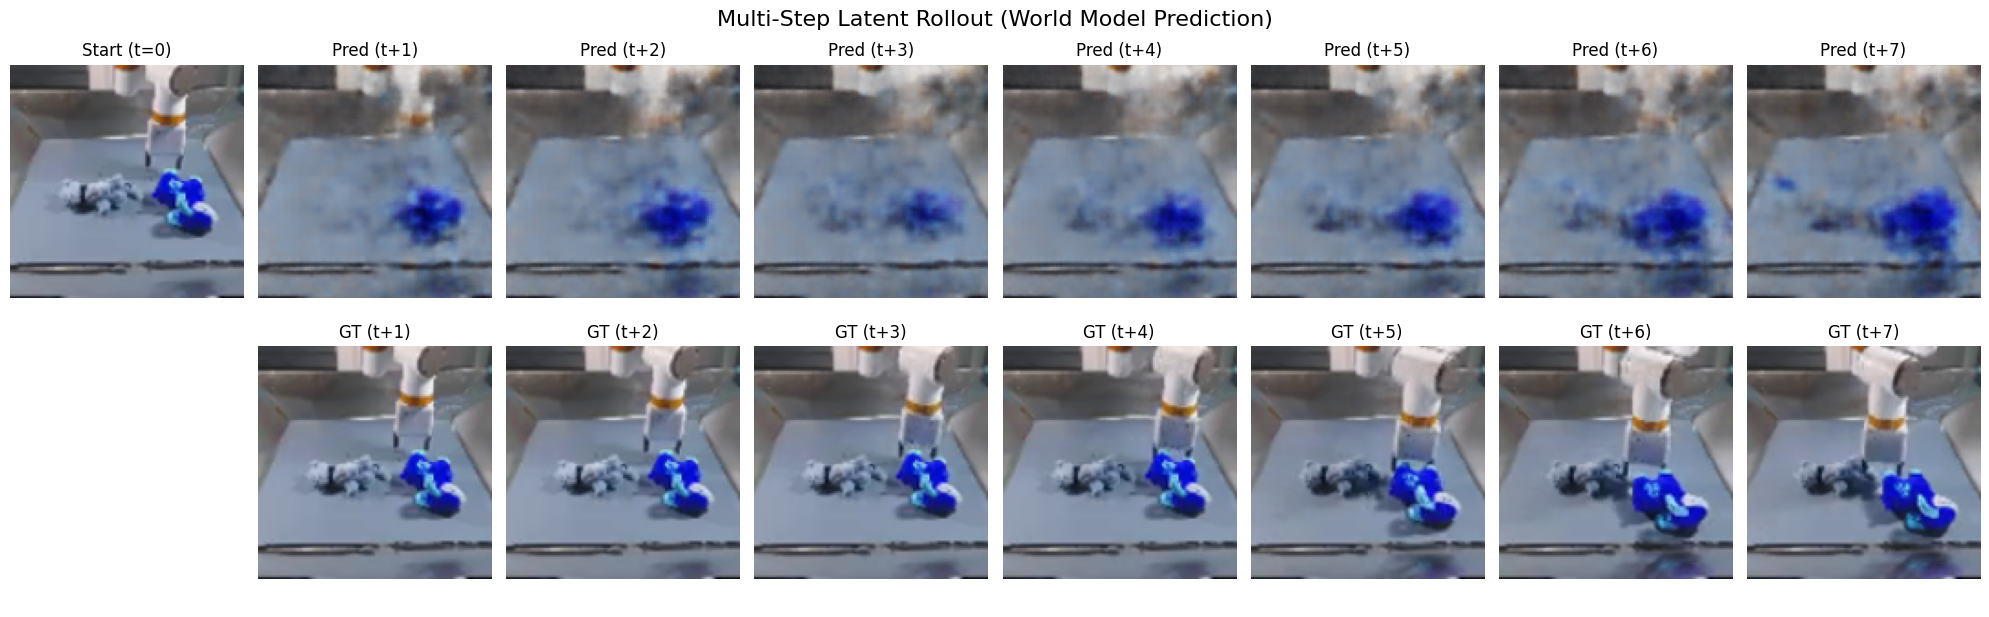

In [24]:
# Extended 10-step rollout visualization
dynamics.eval()
vae.eval()

with torch.no_grad():
    batch = next(iter(val_loader))
    frames = batch['frames'].to(DEVICE)
    actions = batch['actions'].to(DEVICE)

    B, T = frames.shape[0], frames.shape[1]

    # 1. Encode all frames
    x_flat = frames.view(-1, 3, 128, 128)
    mu_all, _ = vae.encode(x_flat)
    z_all = mu_all.view(B, T, LATENT_DIM)

    # 2. Set rollout parameters with safety check
    start_t = 0
    num_steps = min(7, T - start_t - 1)  # Safety: ensure we don't exceed bounds
    
    z_current = z_all[:, start_t]
    h = None
    
    preds = []
    gt_frames = []

    # 3. Auto-regressive rollout
    for step in range(num_steps):
        a_t = actions[:, start_t + step]
        
        # Predict next latent
        z_next, _, _, h = dynamics(z_current, a_t, h)
        
        # Decode for visualization
        recon = vae.decode(z_next)
        preds.append(recon[0].cpu().permute(1, 2, 0).numpy())
        
        # Ground truth comparison
        gt_frames.append(frames[0, start_t + step + 1].cpu().permute(1, 2, 0).numpy())
        
        # Feed prediction back
        z_current = z_next

    # 4. Visualization
    fig, axes = plt.subplots(2, num_steps + 1, figsize=(20, 6))
    
    # Starting frame
    axes[0, 0].imshow(frames[0, start_t].cpu().permute(1, 2, 0).numpy())
    axes[0, 0].set_title("Start (t=0)")
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')

    for i in range(num_steps):
        axes[0, i+1].imshow(np.clip(preds[i], 0, 1))
        axes[0, i+1].set_title(f"Pred (t+{i+1})")
        axes[0, i+1].axis('off')
        
        axes[1, i+1].imshow(gt_frames[i])
        axes[1, i+1].set_title(f"GT (t+{i+1})")
        axes[1, i+1].axis('off')

    plt.tight_layout()
    plt.suptitle("Multi-Step Latent Rollout (World Model Prediction)", y=1.02, fontsize=16)
    plt.show()

In [25]:
# Add this to your visualization code to debug
with torch.no_grad():
    # TEST 1: Can the VAE still see?
    z_test = z_all[:, start_t]
    recon_sanity = vae.decode(z_test) # Direct decode, no dynamics
    
    # TEST 2: Is the dynamics model shifting the latent?
    z_shift, _, _, _ = dynamics(z_test, actions[:, start_t])
    print(f"Latent Difference: {torch.norm(z_test - z_shift).item():.4f}")

Latent Difference: 5.4674


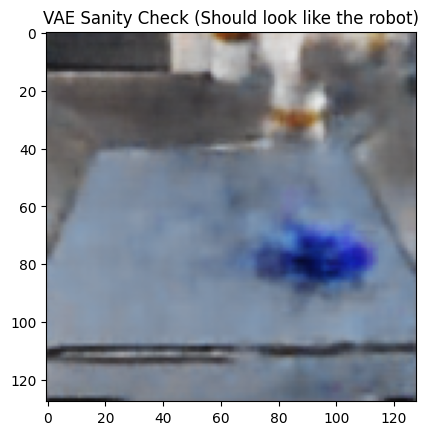

In [26]:
with torch.no_grad():
    # Take one real frame, encode it, and immediately decode it
    sample_frame = frames[0, 0:1] # (1, 3, 128, 128)
    z_mu, _ = vae.encode(sample_frame)
    reconstruction = vae.decode(z_mu)
    
    plt.imshow(reconstruction[0].cpu().permute(1, 2, 0).numpy())
    plt.title("VAE Sanity Check (Should look like the robot)")
    plt.show()

✅ SUCCESS: VAE Weights loaded perfectly.


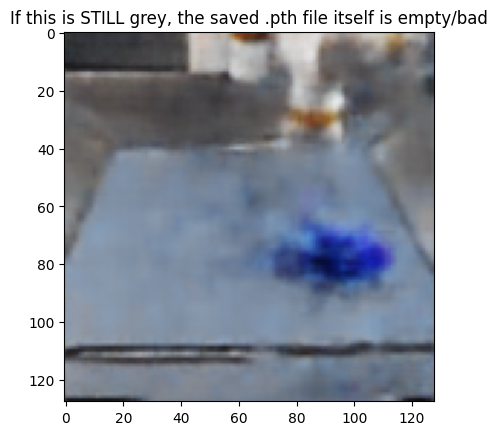

In [ ]:
import torch

# 1. Re-initialize
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)

# 2. Check if file exists
if not os.path.exists(VAE_CHECKPOINT):
    print(f"❌ ERROR: Checkpoint not found at {VAE_CHECKPOINT}")
else:
    # 3. Load with error catching
    try:
        checkpoint = torch.load(VAE_CHECKPOINT, map_location=DEVICE)
        vae.load_state_dict(checkpoint)
        vae.eval()
        print("✅ SUCCESS: VAE Weights loaded perfectly.")
    except Exception as e:
        print(f"❌ ERROR loading weights: {e}")

# 4. Immediate Sanity Check
with torch.no_grad():
    # Grab a real frame from a batch
    batch = next(iter(val_loader))
    real_frame = batch['frames'][0, 0:1].to(DEVICE) 
    
    # Encode and Decode
    mu, _ = vae.encode(real_frame)
    recon = vae.decode(mu)
    
    plt.imshow(recon[0].cpu().permute(1, 2, 0).numpy())
    plt.title("If this is STILL grey, the saved .pth file itself is empty/bad")
    plt.show()

In [28]:
# 1. Check if dynamics is actually changing the latent
dynamics.eval()
vae.eval()

with torch.no_grad():
    batch = next(iter(val_loader))
    frames = batch['frames'].to(DEVICE)
    actions = batch['actions'].to(DEVICE)
    
    # Encode first frame
    x_flat = frames.view(-1, 3, 128, 128)
    mu_all, _ = vae.encode(x_flat)
    z_all = mu_all.view(frames.shape[0], frames.shape[1], LATENT_DIM)
    
    z_current = z_all[0:1, 0]  # (1, LATENT_DIM)
    
    print("Initial latent stats:")
    print(f"  Mean: {z_current.mean().item():.4f}")
    print(f"  Std: {z_current.std().item():.4f}")
    print(f"  Min: {z_current.min().item():.4f}")
    print(f"  Max: {z_current.max().item():.4f}")
    
    # Predict next latent
    a_t = actions[0:1, 0]
    z_next, _, _, _ = dynamics(z_current, a_t, None)
    
    print("\nPredicted latent stats:")
    print(f"  Mean: {z_next.mean().item():.4f}")
    print(f"  Std: {z_next.std().item():.4f}")
    print(f"  Min: {z_next.min().item():.4f}")
    print(f"  Max: {z_next.max().item():.4f}")
    
    print(f"\nLatent change: {(z_next - z_current).abs().mean().item():.6f}")
    
    # Check decoder output
    recon = vae.decode(z_next)
    print(f"\nDecoder output stats:")
    print(f"  Mean: {recon.mean().item():.4f}")
    print(f"  Std: {recon.std().item():.4f}")
    print(f"  Min: {recon.min().item():.4f}")
    print(f"  Max: {recon.max().item():.4f}")

Initial latent stats:
  Mean: -0.0158
  Std: 0.3249
  Min: -1.9603
  Max: 1.2913

Predicted latent stats:
  Mean: -0.0020
  Std: 0.4088
  Min: -1.9881
  Max: 1.4850

Latent change: 0.204091

Decoder output stats:
  Mean: 0.4836
  Std: 0.1407
  Min: 0.0233
  Max: 0.9361


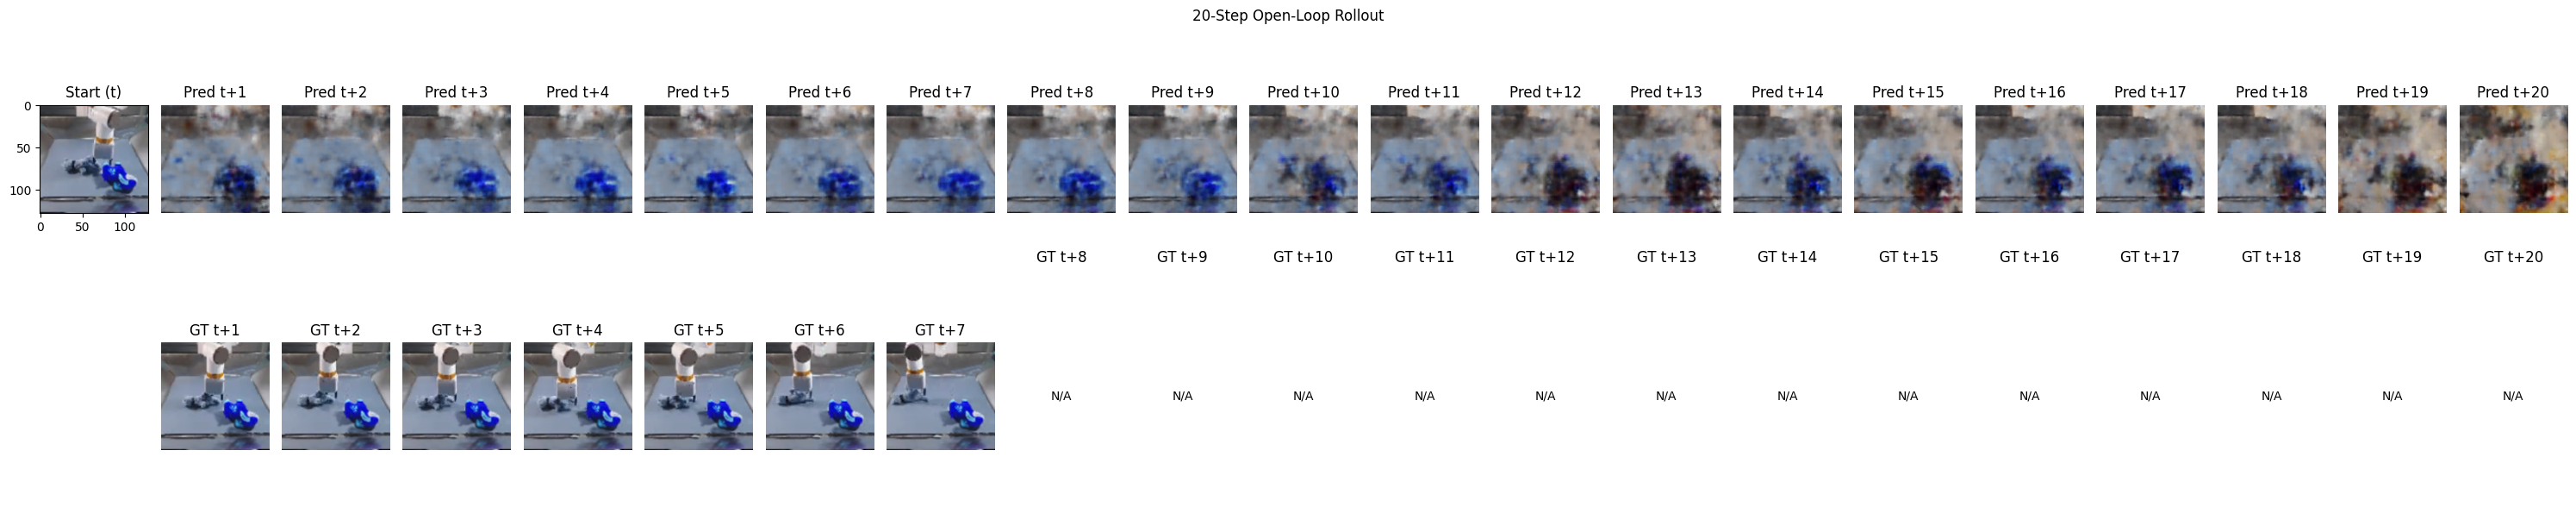

In [29]:
# ────────────────────────────────────────────────
# 20-Step Open-Loop Rollout Visualization
# ────────────────────────────────────────────────

dynamics.eval()
vae.eval()
with torch.no_grad():
    # Take one validation sample
    batch = next(iter(val_loader))
    frames = batch['frames'].to(DEVICE)[0:1]      # first sample only (B=1)
    actions = batch['actions'].to(DEVICE)[0:1]

    T = frames.shape[1]

    # Encode ground truth frames
    x_flat = frames.view(-1, 3, 128, 128)
    mu_all, logvar_all = vae.encode(x_flat)
    z_gt = vae.reparameterize(mu_all, logvar_all).view(1, T, LATENT_DIM)

    # Start from middle frame
    start_t = T // 2
    z_current = z_gt[:, start_t:start_t+1]  # (1, 1, latent_dim)
    h = None

    num_steps = 20
    pred_frames = []
    for step in range(num_steps):
        # Use last action if beyond sequence
        a_t = actions[:, min(start_t + step, actions.shape[1]-1)]
        z_next, _, _, h = dynamics(z_current.squeeze(1), a_t, h)
        recon = vae.decode(z_next)
        pred_frames.append(recon[0].cpu().permute(1, 2, 0).numpy())
        z_current = z_next.unsqueeze(1)

    # Ground truth future frames (if available)
    gt_frames = []
    for i in range(num_steps):
        idx = start_t + i + 1
        if idx < T:
            gt_frames.append(frames[0, idx].cpu().permute(1, 2, 0).numpy())
        else:
            gt_frames.append(None)

    # Plot
    fig, axes = plt.subplots(2, num_steps + 1, figsize=(30, 6))
    # Current
    axes[0, 0].imshow(frames[0, start_t].cpu().permute(1, 2, 0).numpy())
    axes[0, 0].set_title("Start (t)")
    axes[1, 0].axis('off')

    for i in range(num_steps):
        axes[0, i+1].imshow(pred_frames[i])
        axes[0, i+1].set_title(f"Pred t+{i+1}")
        if gt_frames[i] is not None:
            axes[1, i+1].imshow(gt_frames[i])
            axes[1, i+1].set_title(f"GT t+{i+1}")
        else:
            axes[1, i+1].text(0.5, 0.5, "N/A", ha='center', va='center')
            axes[1, i+1].set_title(f"GT t+{i+1}")
        for ax in [axes[0, i+1], axes[1, i+1]]:
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle("20-Step Open-Loop Rollout", y=1.02)
    plt.show()